# OpenCV Camera

In [1]:
# reload library
%load_ext autoreload
%autoreload 2

In [125]:
import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

import cv2

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10) # set default figure width

from slurm import storage
from pprint import pprint
from pathlib import Path

In [126]:
from opencv_camera import CameraCalibration
from opencv_camera import StereoCalibration
from opencv_camera import ChessboardFinder
from opencv_camera import UnDistort
from opencv_camera import bgr2gray, gray2bgr
from opencv_camera import visualizeDistortion
from opencv_camera import drawEpipolarLines
from opencv_camera import findFundamentalMat

In [127]:
!ls

cal_pics                        misc
camera-cal-alt.ipynb            pics
camera-calibration-stereo.ipynb remove
cb.ply                          test-stereo.ipynb
docs                            test.py
grab.py


In [128]:
# See the answer from OpenCV Tutorials
ans = cv2.FileStorage("cal_pics/intrinsics.yml", cv2.FILE_STORAGE_READ)
print("Left camera K1 and D1")
print("-"*40)
print(ans.getNode("M1").mat())
print(ans.getNode("D1").mat())
print("")
print("Right camera K2 and D2")
print("-"*40)
print(ans.getNode("M2").mat())
print(ans.getNode("D2").mat())

Left camera K1 and D1
----------------------------------------
[[534.803   0.    335.686]
 [  0.    534.803 240.662]
 [  0.      0.      1.   ]]
[[ 0.296 -1.035  0.     0.     0.   ]]

Right camera K2 and D2
----------------------------------------
[[534.803   0.    334.557]
 [  0.    534.803 242.053]
 [  0.      0.      1.   ]]
[[-0.169 -0.112  0.     0.     0.   ]]


In [129]:
def readImages(pattern):
    p = list(Path("cal_pics").glob(pattern))
    p.sort()
    return [cv2.imread(str(f),0) for f in p]

imgL = readImages("left*.jpg")
imgR = readImages("right*.jpg")

In [130]:
# plt.imshow(imgL[0], cmap="gray")
# plt.title(f"{imgL[0].shape}");

In [137]:
stereoCal = StereoCalibration()
board = ChessboardFinder((9,6), 1)

ok, cm, sc = stereoCal.calibrate(imgL, imgR, board)

100%|██████████| 13/13 [00:00<00:00, 41.23it/s]


>> RMS: 0.195px

 Camera[(480, 640)]----------------------
  focalLength(x,y): 532.8 532.9 px 
  principlePoint(x,y): 342.5 233.9 px
  distortionCoeffs: [[-0.281  0.025  0.001 -0.     0.163]]



100%|██████████| 13/13 [00:00<00:00, 49.39it/s]


>> RMS: 0.207px

 Camera[(480, 640)]----------------------
  focalLength(x,y): 537.5 537.0 px 
  principlePoint(x,y): 327.6 248.9 px
  distortionCoeffs: [[-0.298  0.15  -0.001  0.    -0.066]]



In [138]:
print(sc)

Camera 1 --------------------------
  focalLength(x,y): 533.4 533.4 px 
  principlePoint(x,y): 342.5 234.7 px
  distortionCoeffs: [[-0.282  0.039  0.001 -0.     0.119]]
Camera 2 --------------------------
  focalLength(x,y): 537.0 536.6 px 
  principlePoint(x,y): 327.4 249.9 px
  distortionCoeffs: [[-0.296  0.139 -0.001  0.    -0.049]]
Extrinsic Camera Parameters -------
  Translation between Left/Right Camera: [-3.327  0.037 -0.005]
  Rotation between Left/Right Camera:
    [[ 1.     0.004  0.004]
     [-0.004  1.    -0.007]
     [-0.004  0.007  1.   ]]
  Essential Matrix:
    [[-0.     0.005  0.037]
     [-0.019  0.024  3.327]
     [-0.025 -3.327  0.024]]
  Fundatmental Matrix:
    [[ 0.    -0.    -0.001]
     [ 0.    -0.    -0.092]
     [ 0.     0.093  1.   ]]



In [45]:
from numpy.linalg import inv, norm

def computeF(K1, K2, R, t):
    """
    OpenCV appears to normalize the F matrix. It can contain
    some really large and really small values. See CSE486
    lecture 19 notes [1] for examples of the F matrix.
    Also see Epipolar Geometery, Table 9.1, last line (Cameras 
    not at inf)[2] for how to calculate it.
    
    [1] http://www.cse.psu.edu/~rtc12/CSE486/lecture19.pdf
    [2] http://www.robots.ox.ac.uk/~vgg/hzbook/hzbook2/HZepipolar.pdf
    """
    t = t.T[0]
    A = (K1 @ R.T @ t)
    C = np.array([
        [    0, -A[2], A[1]],
        [ A[2],     0,-A[0]],
        [-A[1],  A[0],    0]
    ])
    ret = inv(K2).T @ R @ K1.T @ C
    return ret/norm(ret)

In [15]:
ee = findFundamentalMat(sc.K1, sc.K2, sc.R, sc.T)
print(ee) # negative of OpenCV F


[[-0.     0.     0.001]
 [-0.     0.     0.091]
 [-0.    -0.092 -0.992]]


In [123]:
np.allclose(sc.F, -ee,1e-2)  # works, F == -ee

True

In [124]:
np.allclose(sc.F, ee,1e-2)  # fail

False

In [139]:
cm.keys()

dict_keys(['date', 'markerType', 'markerSize', 'imageSize', 'rvecsL', 'tvecsL', 'rvecsR', 'tvecsR', 'objpoints', 'imgpointsL', 'imgpointsR'])

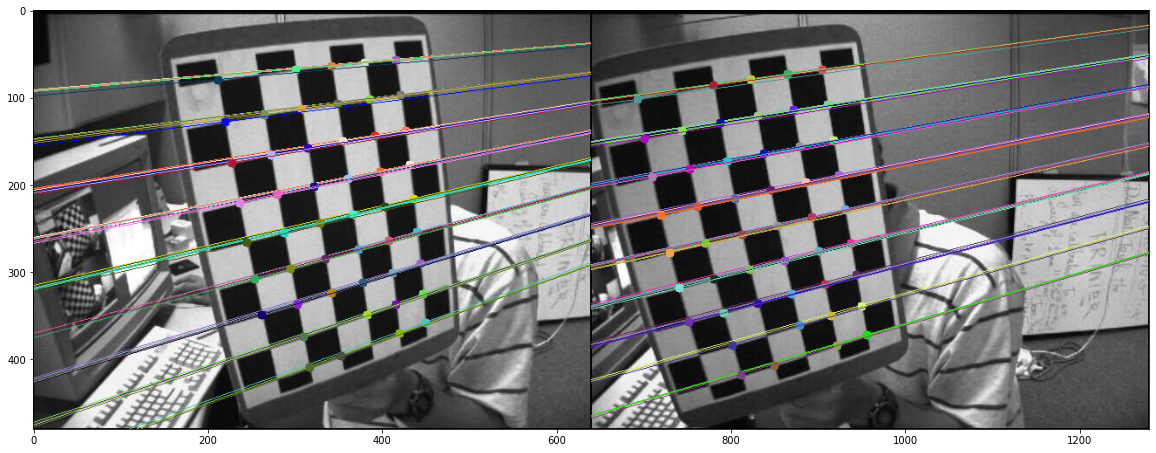

In [140]:
imgnum = 12
im = drawEpipolarLines(
    cm["imgpointsL"][imgnum],
    cm["imgpointsR"][imgnum],
    imgL[imgnum],
    imgR[imgnum])

plt.imshow(im);

In [141]:
print("Camera Matrix:\n", sc.K1)
print("Distortion Coefficients:", sc.d1.ravel())

Camera Matrix:
 [[533.417   0.    342.535]
 [  0.    533.442 234.725]
 [  0.      0.      1.   ]]
Distortion Coefficients: [-0.282  0.039  0.001 -0.     0.119]


```
Intrinsics
----------
Focal length (pixels):    [  535.9158 +/- 0.0000      535.9158 +/- 1.2919    ]
Principal Point (pixels): [  342.2831 +/- 1.3643      235.5708 +/- 1.4770    ]
Radial distortion:        [   -0.2664 +/- 0.0163       -0.0386 +/- 0.1271        0.2384 +/- 0.2763    ]
Tangential distortion:    [    0.0018 +/- 0.0003       -0.0003 +/- 0.0004    ]
Rational distortion:      [    0.0000 +/- 0.0000        0.0000 +/- 0.0000        0.0000 +/- 0.0000    ]
Thin Prism distortion:    [    0.0000 +/- 0.0000        0.0000 +/- 0.0000        0.0000 +/- 0.0000        0.0000 +/- 0.0000    ]
Tilt distortion:          [    0.0000 +/- 0.0000        0.0000 +/- 0.0000    ]
```

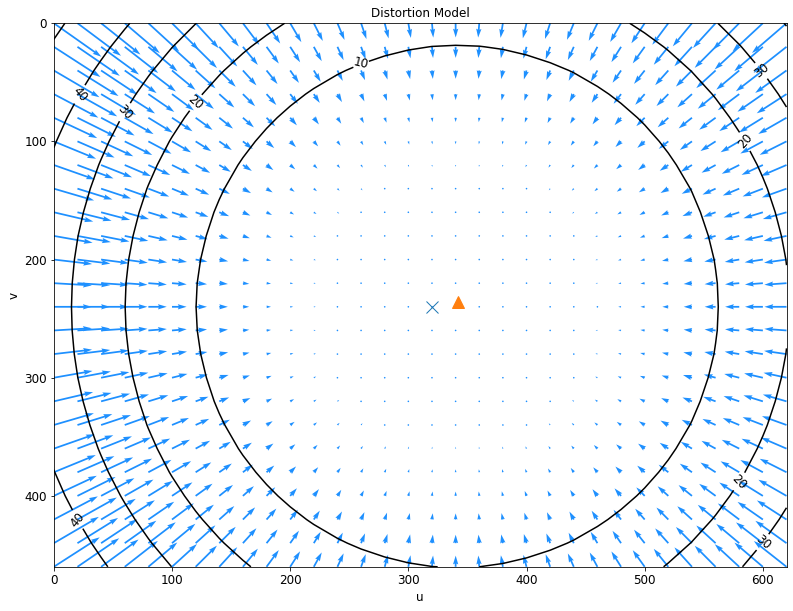

In [142]:
# re-creation of the example here:
# http://amroamroamro.github.io/mexopencv/opencv/calibration_demo.html
M = np.array([
    [536., 0, 342.],
    [0, 536., 236.],
    [0,0,1.]
])

dd = np.array([
    [-0.2664, -0.0386, 0.0018, -0.0003, 0.2384]
])

visualizeDistortion(M, dd,480,640,fontsize=12,contourLevels=5)

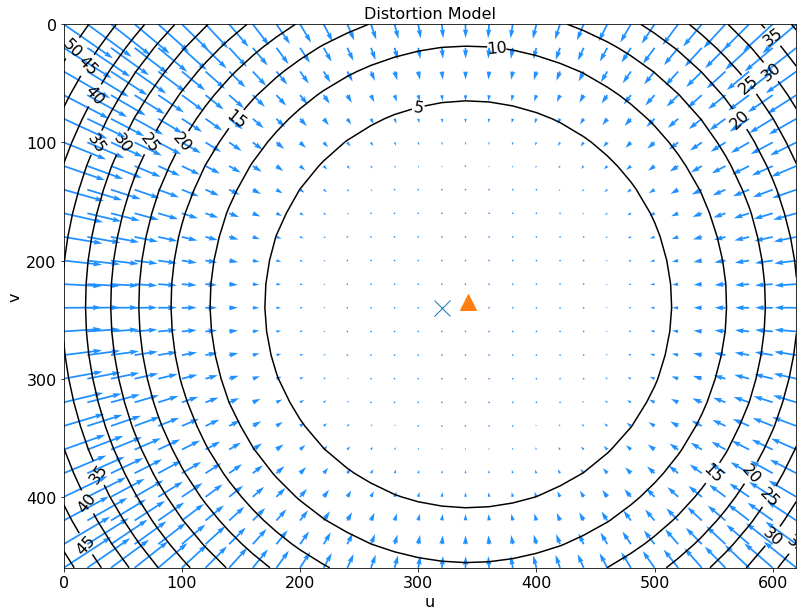

In [143]:
visualizeDistortion(sc.K1, sc.d1,480,640)

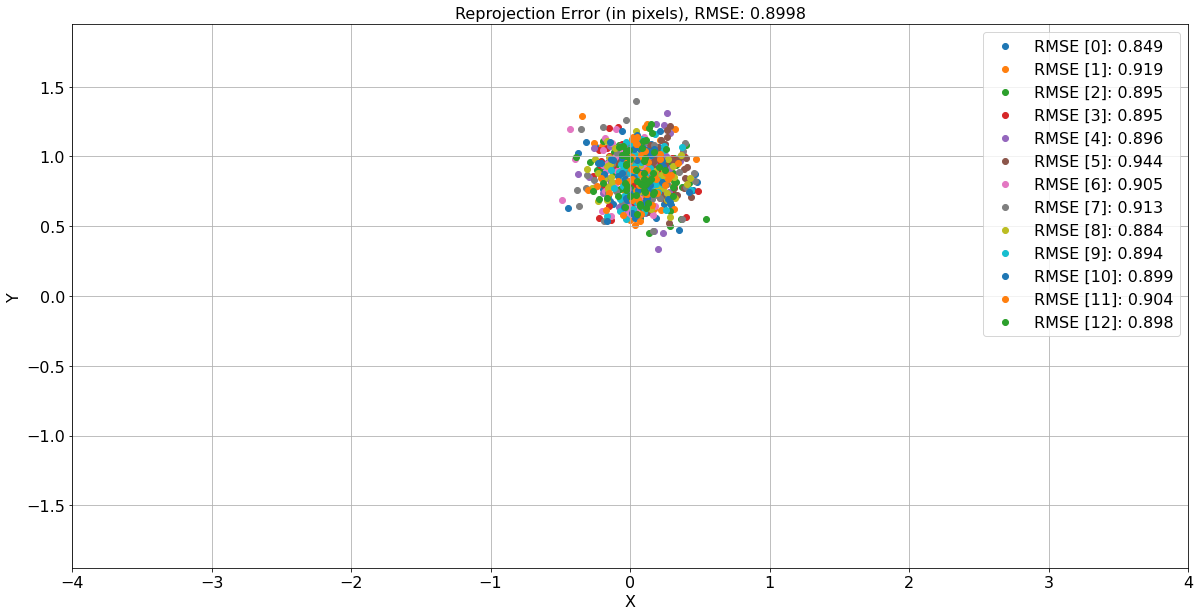

In [144]:
from opencv_camera import computeReprojectionErrors
from opencv_camera import visualizeReprojErrors

em,rms,xy = computeReprojectionErrors(
    cm["imgpointsL"],cm["objpoints"],
    cm["rvecsL"],cm["tvecsL"],
    sc.K1,sc.d1)
    
visualizeReprojErrors(em, rms, xy, xlim=[-4,4], ylim=[-2,2],legend=True)